In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
import rc_rainfall
%matplotlib inline

In [2]:
NETCDF_ENGINE = "h5netcdf"
REGION = "Colombia"

precipitation_pcolormesh_kwargs = {
    "cmap": "Blues",
    "transform": ccrs.PlateCarree(),
    "vmin": 0,
}

# Load Dataset

In [21]:
trmm = xr.open_dataarray(f"data/TRMM_{REGION}.nc", engine=NETCDF_ENGINE)
gpm = xr.open_dataarray(f"data/GPM_{REGION}.nc", engine=NETCDF_ENGINE)
trmm_monthly = xr.open_dataarray(
    f"data/TRMM_Monthly_{REGION}.nc", engine=NETCDF_ENGINE
) * 24 # mm/hr to mm/day

oisst_nino34_anomaly = xr.open_dataarray(f"data/oisst_subset.nc", engine=NETCDF_ENGINE).sel(**rc_rainfall.NINO34_BOX)

# Map

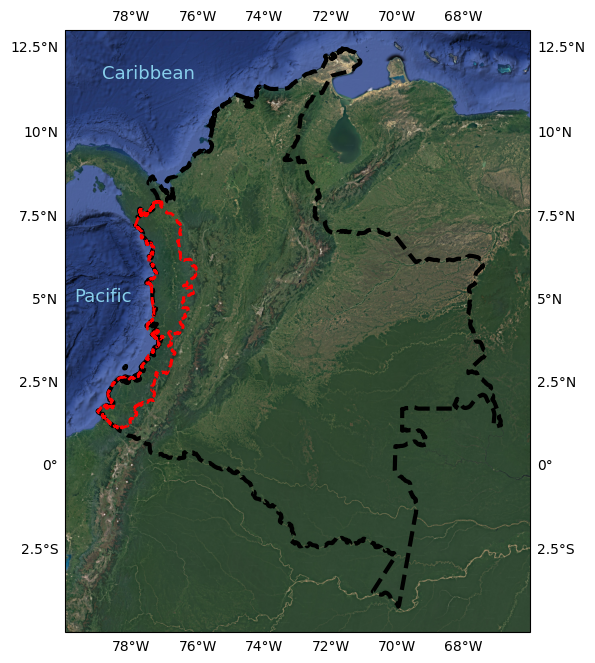

In [5]:
google_terrain = cimgt.GoogleTiles(style="satellite")
fig, ax = plt.subplots(figsize=(6, 9), subplot_kw={"projection": google_terrain.crs})
ax.set_extent_colombia()
ax.add_image(google_terrain, 9)
ax.add_country_border(
    "Colombia", facecolor="none", edgecolor="black", linestyle="--", linewidth=3
)

# Region of Interest (Pacific)
reader = Reader(rc_rainfall.colombia_pacific_shapefile())
shape_feature = cfeature.ShapelyFeature(reader.geometries(), ccrs.PlateCarree())
ax.add_feature(
    shape_feature, facecolor="none", edgecolor="red", linestyle="--", linewidth=2
);

ax.text(0.02, 0.55, "Pacific", transform=ax.transAxes, fontsize=13, color="skyblue");
ax.text(0.08, 0.92, "Caribbean", transform=ax.transAxes, fontsize=13, color="skyblue");
ax.gridlines(draw_labels=True, linewidth=0);

# Data Visualization

## Climatology

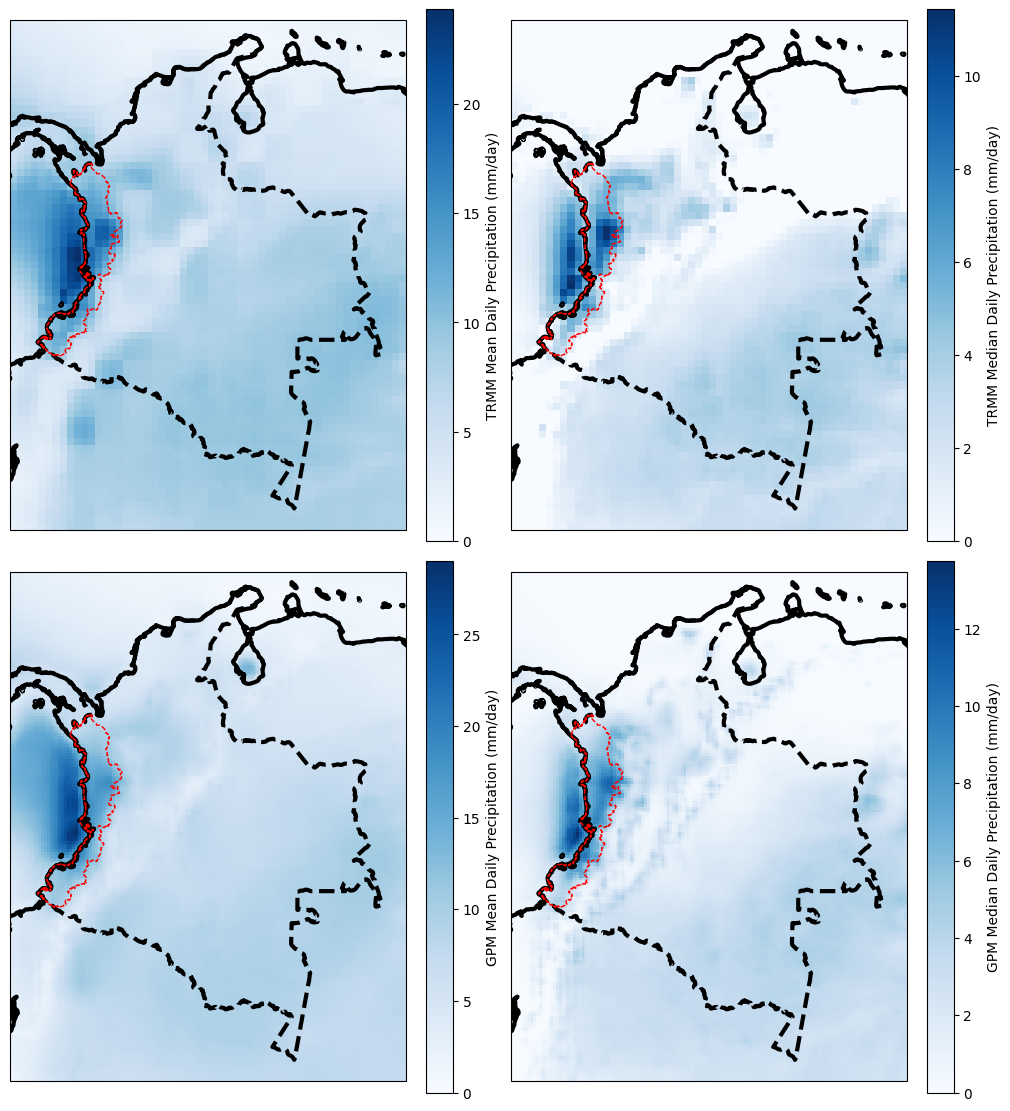

In [ ]:
datasets = ["TRMM", "GPM"]
statistics = ["Mean", "Median"]

fig, axes = plt.subplots(
    len(datasets),
    len(statistics),
    figsize=(10, 11),
    subplot_kw={"projection": ccrs.PlateCarree()},
    layout="constrained",
    squeeze=False,
)
for ax in axes.flat:
    ax.set_colombia()
    ax.add_feature(shape_feature, facecolor="none", edgecolor="red", linestyle="--")

for i in range(len(datasets)):
    for j in range(len(statistics)):
        dataset = datasets[i]
        stat = statistics[j]
        ax = axes[i, j]
        if dataset == "TRMM":
            data = trmm
        elif dataset == "GPM":
            data = gpm

        if stat == "Mean":
            data = data.mean(dim="time")
        elif stat == "Median":
            data = data.median(dim="time")

        data.plot(
            ax=ax,
            **precipitation_pcolormesh_kwargs,
            cbar_kwargs={"label": f"{dataset} {stat} Daily Precipitation (mm/day)"},
        )

## Animation of Daily Precipitation

In [ ]:
fig, ax = plt.subplots(
    figsize=(9, 9),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=True,
)
ax.set_colombia()


# TODO: make whole animation generation a function
mesh = xr.zeros_like(trmm[0]).plot(
    ax=ax,
    **precipitation_pcolormesh_kwargs,
    vmax=np.max(trmm),
    cbar_kwargs={"label": "GPM Daily Precipitation (mm/day)"},
)
ax.set_title(None)


def update_mesh(t):
    data = trmm[t]
    ax.set_title(data._title_for_slice(), fontsize=22)
    mesh.set_array(data)
    return mesh, ax.title


animation = FuncAnimation(
    fig, update_mesh, frames=len(trmm), interval=50, blit=True, cache_frame_data=False
)
animation.save("images/trmm_colombia.mp4")

## Seasaonal and Monthly Mean

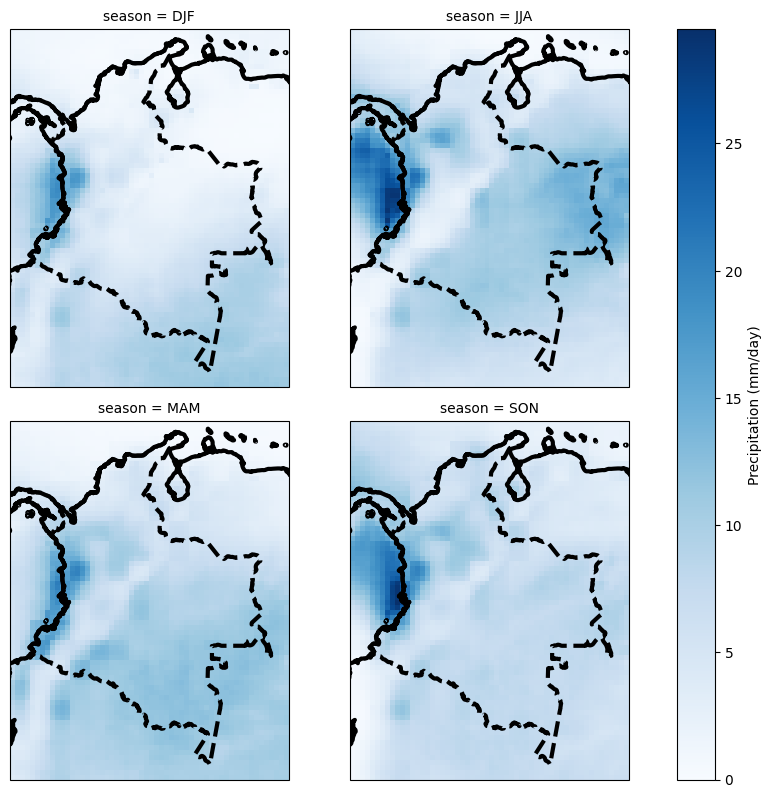

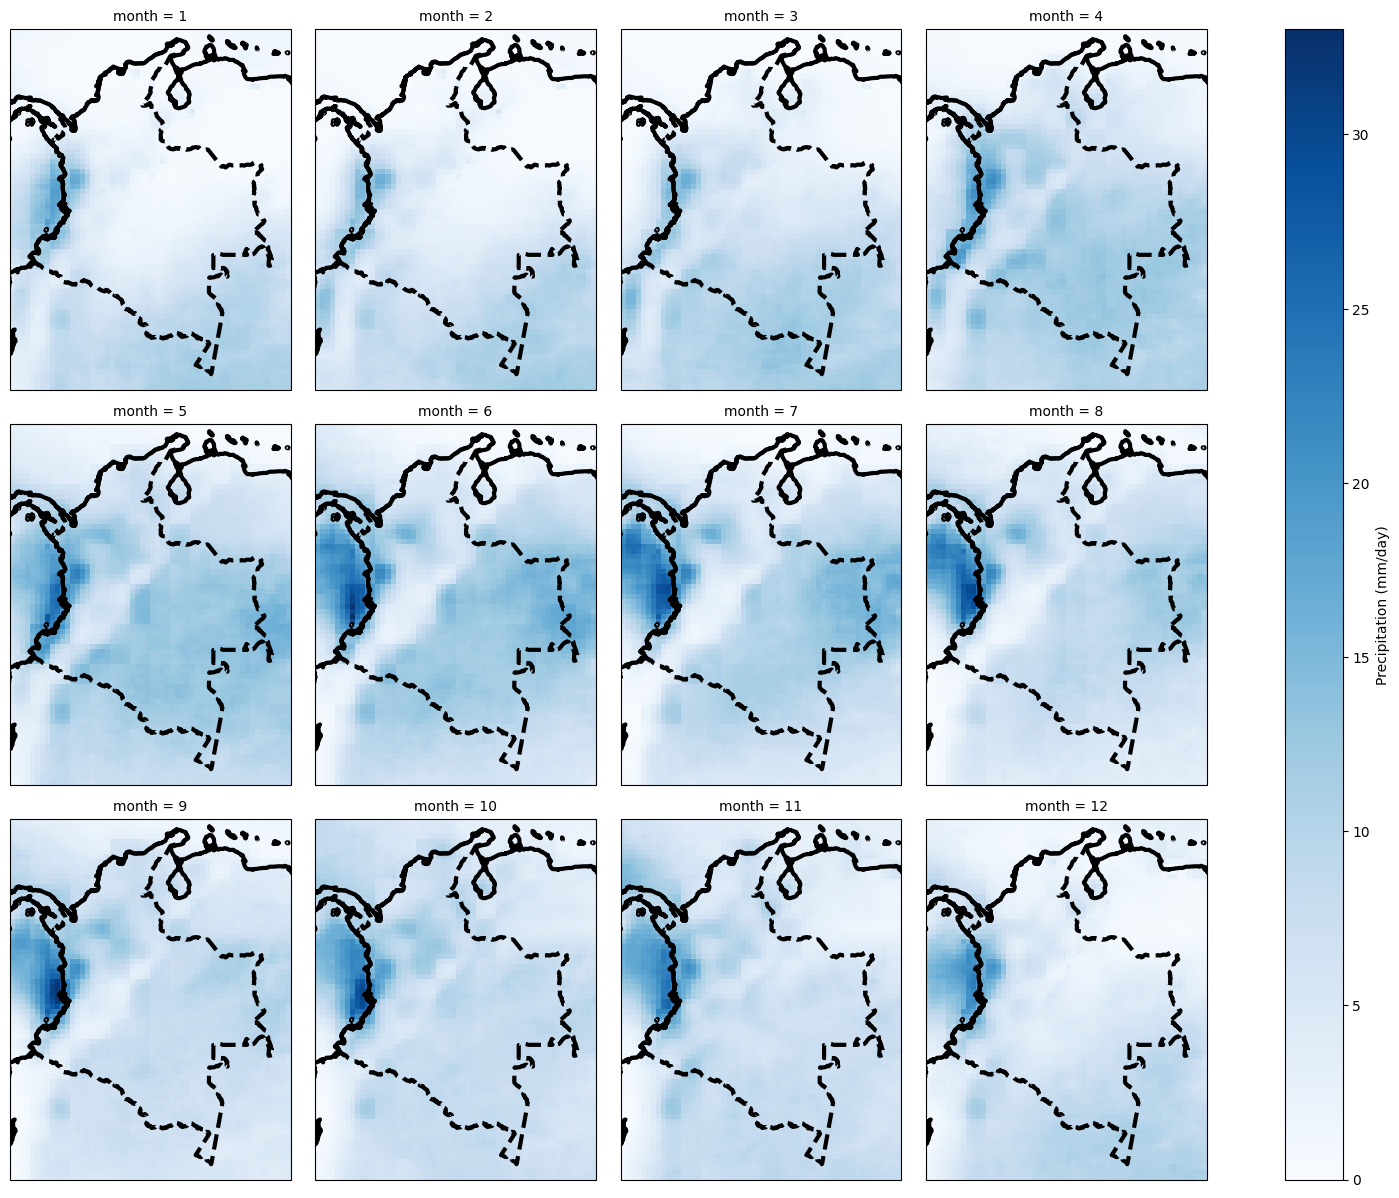

In [ ]:
trmm_seasonal_climotology = trmm.groupby("time.season").mean("time")
trmm_monthly_climotology = trmm.groupby("time.month").mean("time")

seasonal_plot = trmm_seasonal_climotology.plot(
    col="season",
    col_wrap=2,
    **precipitation_pcolormesh_kwargs,
    vmax=np.max(trmm_seasonal_climotology),
    figsize=(10, 8),
    subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={"label": "Precipitation (mm/day)"},
)

for ax in seasonal_plot.axs.flat:
    ax.set_colombia()

monthly_plot = trmm_monthly_climotology.plot(
    col="month",
    col_wrap=4,
    **precipitation_pcolormesh_kwargs,
    vmax=np.max(trmm_monthly_climotology),
    figsize=(16, 12),
    subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={"label": "Precipitation (mm/day)"},
)

for ax in monthly_plot.axs.flat:
    ax.set_colombia()

# Analysis of Regional Mean Precipitation (Pacific Region)

## Regional Mask for Aggregation

In [9]:
# Apply the mask to the precipitation data
weights_trmm = rc_rainfall.latitudinal_weight(trmm) * rc_rainfall.xr_mask_pacific(trmm)
weights_gpm = rc_rainfall.latitudinal_weight(gpm) * rc_rainfall.xr_mask_pacific(gpm)
weights_nino34 = rc_rainfall.latitudinal_weight(oisst_nino34_anomaly)

## Daily Time Series

In [22]:
mean_trmm = rc_rainfall.spatial_mean_series(trmm, weights_trmm)
mean_gpm = rc_rainfall.spatial_mean_series(gpm, weights_gpm)
mean_trmm_monthly = rc_rainfall.spatial_mean_series(trmm_monthly, weights_trmm)

In [23]:
mean_nino34_anomaly = rc_rainfall.spatial_mean_series(oisst_nino34_anomaly, weights_nino34)

### Visualization of TRMM (Daily Series and Distribution)

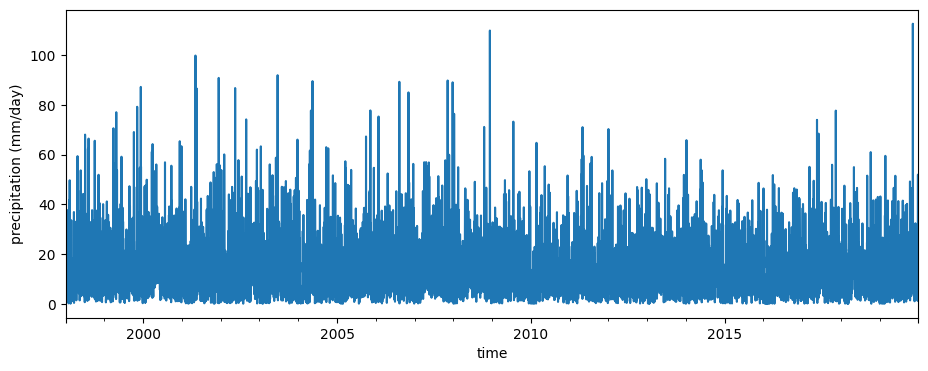

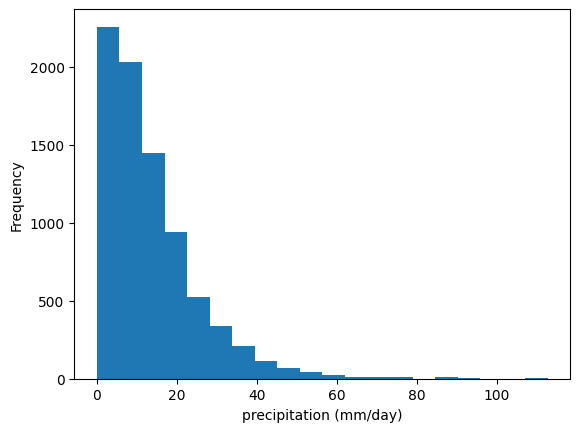

In [24]:
mean_trmm.plot(figsize=(11, 4), ylabel=f"{mean_trmm.name} (mm/day)");
fig = plt.figure()
mean_trmm.plot.hist(bins=20, xlabel=f"{mean_trmm.name} (mm/day)");

## Number of Extremes (Each Month)

### TRMM

Extreme Threshold: 36.05569915771483


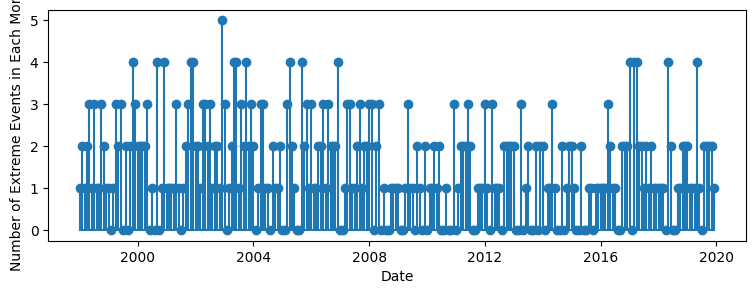

In [25]:
extreme_threshold = mean_trmm.quantile(0.95)
print(f"Extreme Threshold: {extreme_threshold}")
is_extreme = mean_trmm > extreme_threshold
n_extreme = is_extreme.resample("MS").sum()
fig, ax = plt.subplots(figsize=(9, 3))
ax.set_xlabel("Date")
ax.set_ylabel("Number of Extreme Events in Each Month")
ax.stem(n_extreme.index, n_extreme, basefmt="");

## Monthly Precipitation Time Series

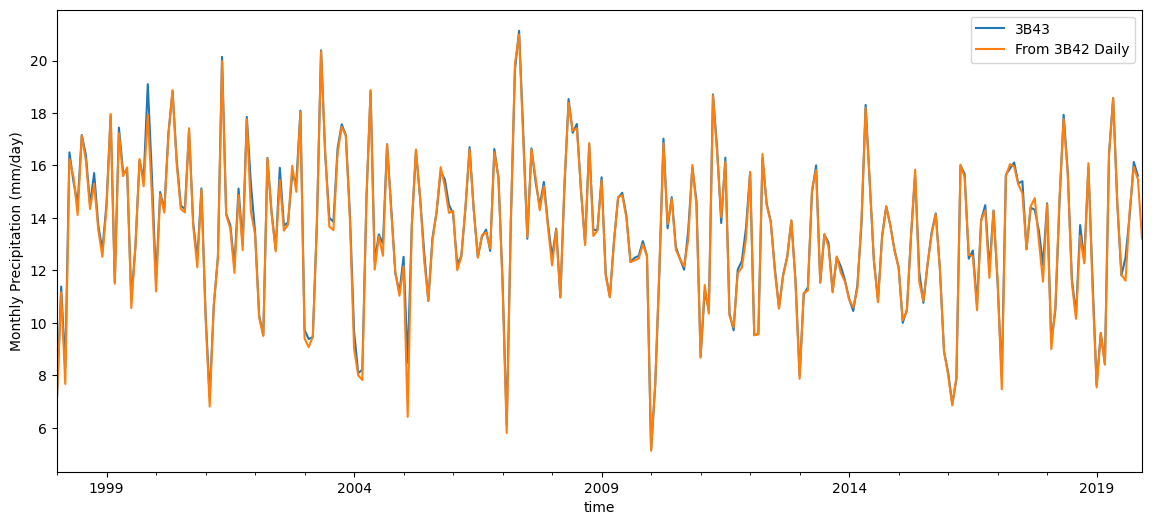

In [26]:
# something is wrong with this plot ...
trmm_monthly_from_daily = mean_trmm.resample("MS").mean()
gpm_monthly_from_daily = mean_gpm.resample("MS").mean()
trmm_monthly_df = pd.concat(
    [mean_trmm_monthly, trmm_monthly_from_daily], axis=1
)
trmm_monthly_df.columns = ["3B43", "From 3B42 Daily"]
trmm_monthly_df.name = "Monthly Precipitation (mm/day)"
trmm_monthly_df.plot(figsize=(14, 6), ylabel=trmm_monthly_df.name);

### Climatology

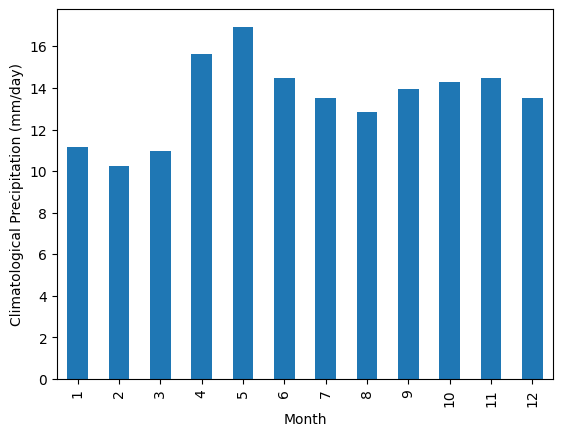

In [27]:
trmm_monthly_climatology = mean_trmm_monthly.groupby(mean_trmm_monthly.index.month).mean()
trmm_monthly_climatology.plot.bar(xlabel="Month", ylabel="Climatological Precipitation (mm/day)");

### Anomalies

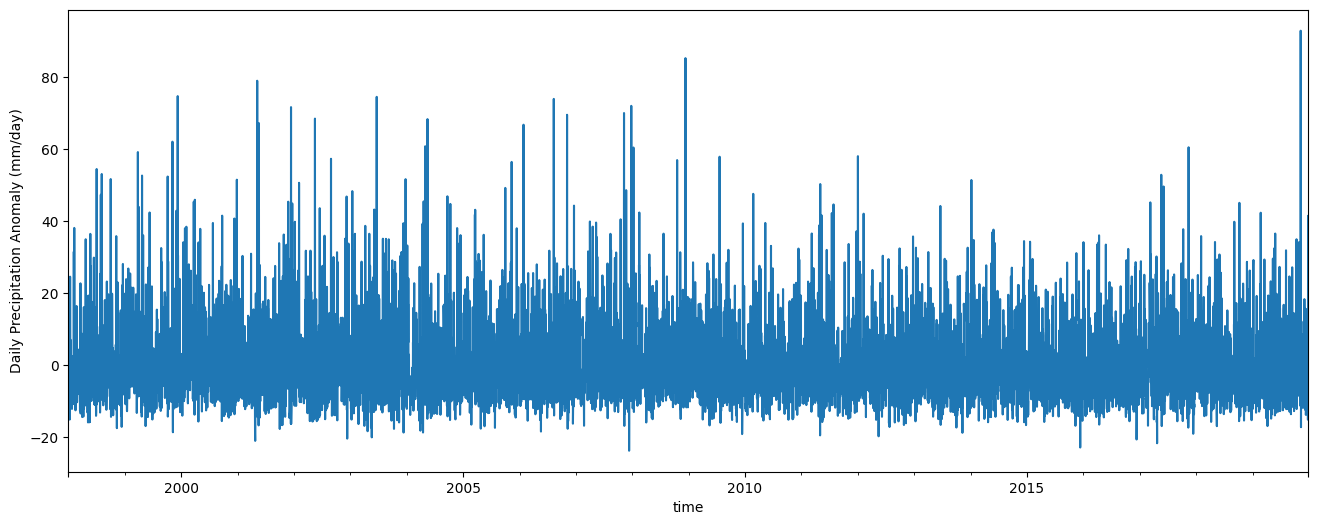

In [28]:
trmm_daily_anomaly = mean_trmm.groupby(mean_trmm.index.dayofyear).transform(lambda x: x - x.mean())
trmm_daily_anomaly.plot(figsize=(16, 6), ylabel="Daily Precipitation Anomaly (mm/day)");

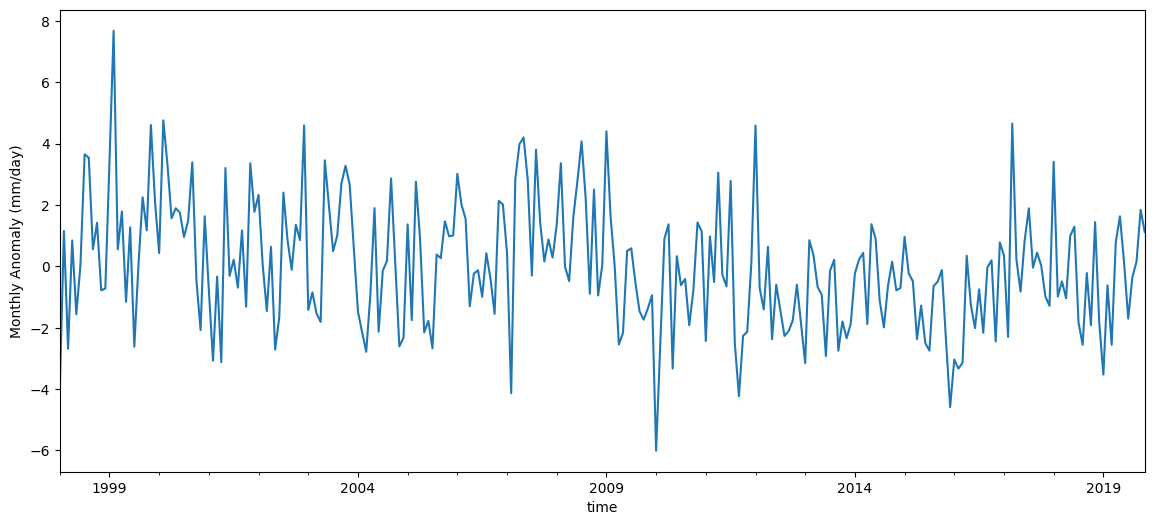

In [29]:
trmm_monthly_anomaly: pd.Series = mean_trmm_monthly.groupby(mean_trmm_monthly.index.month).transform(lambda x: x - x.mean())
trmm_monthly_anomaly.plot(figsize=(14, 6), ylabel="Monthly Anomaly (mm/day)");

## SST and Nino 3.4

In [31]:
df = pd.read_csv("data/sstoi.indices.txt", sep=r"\s+")
# Combine 'YR' and 'MON' into a datetime index
df["DATE"] = pd.to_datetime(df["YR"].astype(str) + "-" + df["MON"].astype(str))
df.set_index("DATE", inplace=True)

# Drop the now redundant columns
df.drop(["YR", "MON"], axis=1, inplace=True)
df.rename(columns={"ANOM": "NINO1+2 ANOM", "ANOM.1": "NINO3 ANOM", "ANOM.2": "NINO4 ANOM", "ANOM.3": "NINO3.4 ANOM"}, inplace=True)
df

,NINO1+2,NINO1+2 ANOM,NINO3,NINO3 ANOM,NINO4,NINO4 ANOM,NINO3.4,NINO3.4 ANOM
DATE,,,,,,,,
1982-01-01,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08
1982-02-01,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20
1982-03-01,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14
1982-04-01,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02
1982-05-01,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49
...,...,...,...,...,...,...,...,...
2023-11-01,23.85,2.22,27.28,2.08,30.12,1.44,28.72,1.90
2023-12-01,24.25,1.41,27.33,2.06,29.84,1.39,28.64,1.99
2024-01-01,25.35,0.83,27.55,1.87,29.67,1.45,28.34,1.78


<Axes: title={'center': 'NINO3.4 Daily SST Anomaly (°C)'}, xlabel='time'>

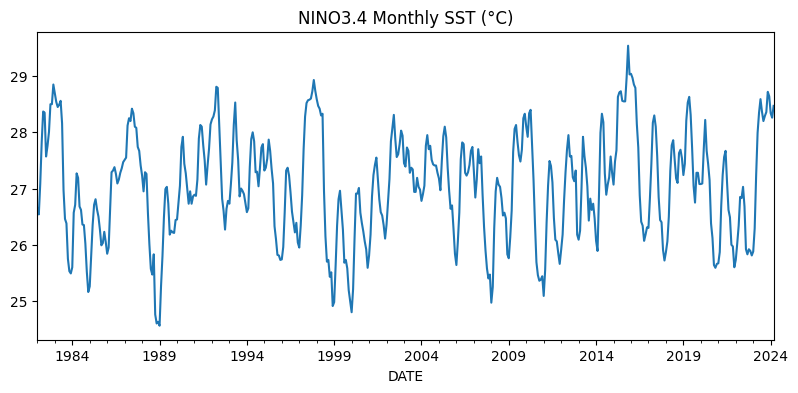

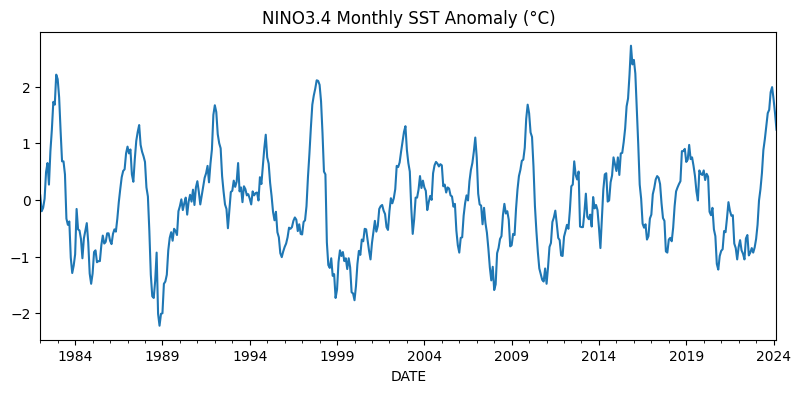

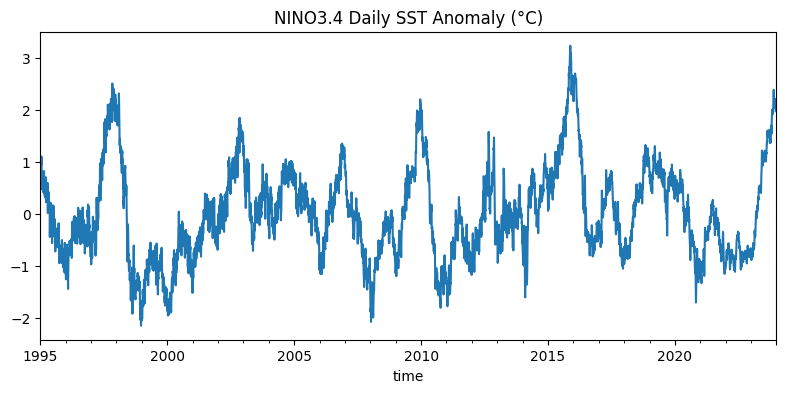

In [32]:
figsize = (9.5, 4)
df["NINO3.4"].plot(figsize=figsize, title="NINO3.4 Monthly SST (°C)")
fig, ax = plt.subplots(figsize=figsize)
df["NINO3.4 ANOM"].plot(figsize=figsize, title="NINO3.4 Monthly SST Anomaly (°C)")
fig, ax = plt.subplots(figsize=figsize)
mean_nino34_anomaly.plot(figsize=figsize, title="NINO3.4 Daily SST Anomaly (°C)")

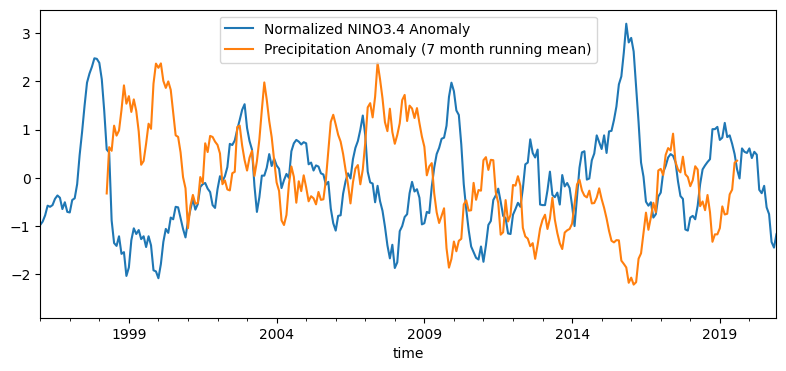

In [33]:
fig, ax = plt.subplots(figsize=(9.5, 4))
normalized_nino34_anomaly = df["NINO3.4 ANOM"] / df["NINO3.4 ANOM"].std()
normalized_nino34_anomaly.plot(ax=ax, label="Normalized NINO3.4 Anomaly")

normalized_smoothed_precipitation_anomaly = trmm_monthly_anomaly.rolling(window=7, center=True).mean()
normalized_smoothed_precipitation_anomaly /= normalized_smoothed_precipitation_anomaly.std()
normalized_smoothed_precipitation_anomaly.plot(ax=ax, label="Precipitation Anomaly (7 month running mean)")
"""
normalized_smoothed_precipitation = mean_trmm_monthly.rolling(
    window=7, center=True
).mean()
normalized_smoothed_precipitation -= normalized_smoothed_precipitation.mean()
normalized_smoothed_precipitation /= normalized_smoothed_precipitation.std()
normalized_smoothed_precipitation.plot(ax=ax, label="Smoothed Precipitation")

normalized_nino34 = df["NINO3.4"]
normalized_nino34 -= normalized_nino34.mean()
normalized_nino34 /= normalized_nino34.std()
normalized_nino34.plot(ax=ax, label="Normalized NINO3.4")
"""

#ax.stem(n_extreme.index, n_extreme-2, linefmt="C3-", basefmt="C3")
ax.legend();
ax.set_xlim(pd.Timestamp("1996-01-01"), pd.Timestamp("2020-12-31"));

## Lead and Lag Correlation

In [34]:
extented_trmm_anomaly = trmm_daily_anomaly.reindex_like(mean_nino34_anomaly)

In [35]:
MAX_LAG = 200
lags = range(-MAX_LAG, MAX_LAG+1)
correlation_method = ["pearson", "spearman", "kendall"]
correlation = pd.DataFrame(0.0, index=lags, columns=correlation_method)

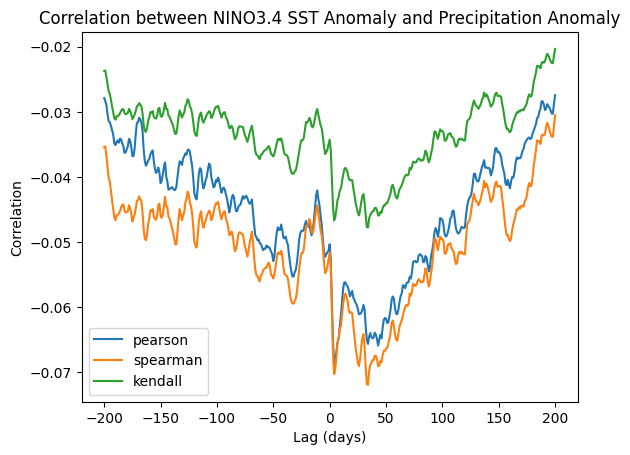

In [36]:
for lag in lags:
    shifted_precipitation = extented_trmm_anomaly.shift(-lag)
    for method in correlation_method:
        correlation.loc[lag, method] = mean_nino34_anomaly.corr(shifted_precipitation, method=method)

correlation.plot(title="Correlation between NINO3.4 SST Anomaly and Precipitation Anomaly", ylabel="Correlation", xlabel="Lag (days)");
